# CONTENT

#### 1- Importing libraries and dataset
#### 2- Data Wrangling/Cleaning:
        01. Editing location column
        02. Fuzzy matching location column
        03. Editing orginal location column
        04. Including ward column
        05. Merging with ward demographics
        06. Including distance to nearest points of interest, schools, bus stations, places of worship
#### 3- Exporting cleaned and wrangled datastet

## 1 Importing libraries and dataset

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import folium
import json
import geopandas as gpd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


In [2]:
#importing datasets
#defining path 
path=r'/Users/Amaikuru/Desktop/Toronto Bus Delays'
#importing data
df=pd.read_pickle(os.path.join(path, '02 Data','Prepared', 'bus_delays_cleaned.pkl'))
#importing bus stops csv
stops=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'stop_routes.csv'))

## 2 Data Wrangling/ Cleaning

### 01. Editing Location column

#### I will be editing the location column to fix wrong formating  and allow for visualization

In [3]:
stops.columns

Index(['stop_id', 'stop_code', 'stop_name', 'route_id', 'route_short_name',
       'stop_lat', 'stop_lon'],
      dtype='object')

In [4]:
#the column stop_name in the stops dataset is the same as the Location column in the delays dataset,
#the stop_name column is in the correct format
stops[['stop_name']].head()

stop_name
0                            Don Mills Station
1     Don Mills Rd at Leith Hill Rd North Side
2  Don Mills Rd at Fairview Mall Dr North Side
3                  Don Mills Rd at Godstone Rd
4                  Don Mills Rd at Deerford Rd

In [5]:
#the column route_short_name in the stops dataset is the same as the Route column in the delays dataset
stops[['route_short_name']].head()

route_short_name
0                10
1                10
2                10
3                10
4                10

In [6]:
#changing stop_name entries to uppercase to match delays Location column
stops['stop_name'] = stops['stop_name'].str.upper()

In [7]:
#making subset of data with route_short_name and stop_name columns
stops2=stops[['stop_name','route_short_name']]

In [8]:
stops2.head()

stop_name  route_short_name
0                            DON MILLS STATION                10
1     DON MILLS RD AT LEITH HILL RD NORTH SIDE                10
2  DON MILLS RD AT FAIRVIEW MALL DR NORTH SIDE                10
3                  DON MILLS RD AT GODSTONE RD                10
4                  DON MILLS RD AT DEERFORD RD                10

In [9]:
df.shape

(74767, 9)

In [10]:

stops2.shape

(4216138, 2)

In [11]:
#creating dataframe with unique stops (location and route) values from delay dataset
unique_loc = pd.DataFrame(df[['Location','Route']].value_counts().reset_index().values,
                          columns=["Location", "Route", "Count"])

In [12]:
#there are 7659 unique stops
unique_loc

Location Route Count
0          FINCH WEST STATION    36   670
1      SCARBOROUGH CENTRE STA   133   503
2       EGLINTON WEST STATION    63   449
3             KENNEDY STATION    34   440
4      PIONEER VILLAGE STATIO    60   433
...                       ...   ...   ...
19876        INDUSTRY AND RAY   171     1
19877        INDUSTRY AND RAY    32     1
19878        INDUSTRY AND RAY    89     1
19879  INDUSTRY AND TODD BAYL     6     1
19880                ZOO LOOP    86     1

[19881 rows x 3 columns]

In [13]:
#generating list of locations from stops with delays
loc_list=list(unique_loc['Location'])
len(loc_list)

19881

In [14]:
#generating list of locations from all  stops in stops dataset
stopslist=list(stops2['stop_name'])
len(stopslist)

4216138

In [15]:
#using set to find unique stops
stops_set=set(stopslist)

In [16]:
len(stops_set)

7629

In [17]:
#reverting to list
stop_list=list(stops_set)

In [18]:
#looking for locations that are not in the stops dataset but are in the delays dataset
#these are the locations with the wrong format or
missing=[]
for loc in loc_list:
    if loc not in stop_list:
        missing.append(loc)

In [19]:
#almost all the locations are in the wrong format
len(missing)

18903

In [20]:
#changing route_short_name to string
stops2['route_short_name']=stops2['route_short_name'].astype(str)

/var/folders/6_/ng_hc75d34d6mrrv7c0dv1380000gn/T/ipykernel_12542/1446055580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stops2['route_short_name']=stops2['route_short_name'].astype(str)


### 02. Fuzzy matching location  and routes columns

In [21]:
#creating dataframe with unique stops (location and route) values from stops2 subset 
unique_stops= pd.DataFrame(stops2[['stop_name','route_short_name']].value_counts().reset_index().values,
                          columns=["stop_name", "route_short_name", "Count"])

In [22]:
unique_stops.shape

(13493, 3)

In [23]:
#joining route and location columns to begin looking for similar values
#stops 
unique_stops['Joined']=unique_stops['stop_name']+'-'+unique_stops['route_short_name']
#delays
unique_loc['Joined']=unique_loc['Location']+'-'+unique_loc['Route']

In [24]:
unique_stops.head(100)

stop_name route_short_name Count  \
0                FINCH WEST STATION               36  4001   
1             EGLINTON WEST STATION               32  3495   
2   KING ST WEST AT JOE SHUSTER WAY              504  3396   
3           KING ST WEST AT SHAW ST              504  3396   
4        KING ST WEST AT SUDBURY ST              504  3396   
..                              ...              ...   ...   
95   KENNEDY RD AT RANSTONE GARDENS               43  1519   
96       KENNEDY RD AT ELLESMERE RD               43  1519   
97           KENNEDY RD AT FLORA DR               43  1519   
98        KENNEDY RD AT MUNHAM GATE               43  1519   
99         KENNEDY RD AT RADNOR AVE               43  1519   

                                 Joined  
0                 FINCH WEST STATION-36  
1              EGLINTON WEST STATION-32  
2   KING ST WEST AT JOE SHUSTER WAY-504  
3           KING ST WEST AT SHAW ST-504  
4        KING ST WEST AT SUDBURY ST-504  
..                                  ...  
95    KENNEDY RD AT RANSTONE GARDENS-43  
96        KENNEDY RD AT ELLESMERE RD-43  
97            KENNEDY RD AT FLORA DR-43  
98         KENNEDY RD AT MUNHAM GATE-43  
99          KENNEDY RD AT RADNOR AVE-43  

[100 rows x 4 columns]

In [25]:
len(unique_stops['Joined'].unique())

13493

In [26]:
#creating list of joined columns
stop_joined=list(unique_stops['Joined'])
delay_joined=list(unique_loc['Joined'])

In [27]:
len(stop_joined)

13493

In [28]:
#we need 7401 matches
len(delay_joined)

19881

In [29]:
#finding best matches and match percentage for delay locations in stop names
best_matches = [max([(fuzz.token_set_ratio(i,j),i,j) for j  in stop_joined]) for i in delay_joined]

In [30]:
#the best match for every location has been found
len(best_matches)

19881

In [31]:
#best matches to datatframe
matches= pd.DataFrame(best_matches, columns =['similarity', 'original', 'match'])

In [32]:
matches

similarity                    original  \
0             100       FINCH WEST STATION-36   
1              93  SCARBOROUGH CENTRE STA-133   
2             100    EGLINTON WEST STATION-63   
3             100          KENNEDY STATION-34   
4              98   PIONEER VILLAGE STATIO-60   
...           ...                         ...   
19876          89        INDUSTRY AND RAY-171   
19877          77         INDUSTRY AND RAY-32   
19878          77         INDUSTRY AND RAY-89   
19879          72    INDUSTRY AND TODD BAYL-6   
19880          78                 ZOO LOOP-86   

                                         match  
0                        FINCH WEST STATION-36  
1               SCARBOROUGH CENTRE STATION-133  
2                     EGLINTON WEST STATION-63  
3                           KENNEDY STATION-34  
4                   PIONEER VILLAGE STATION-60  
...                                        ...  
19876               INDUSTRY ST AT RAY AVE-171  
19877                INDUSTRY ST AT RAY AVE-71  
19878                INDUSTRY ST AT RAY AVE-71  
19879       INDUSTRY ST AT TODD BAYLIS BLVD-71  
19880  MEADOWVALE LOOP AT SHEPPARD AVE EAST-86  

[19881 rows x 3 columns]

In [33]:
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

In [34]:
#locating similarities less than 90
matches.loc[matches['similarity']<90].sort_values('similarity')

similarity                                    original  \
18458          44                                     EVRY-76   
17359          44                                     MCVP-42   
19802          44                                     HUML-96   
7853           44                                     MP58-66   
6960           44                                     MMCL-35   
3071           44                                     SLPM-46   
10252          44                                     SLMP-46   
6476           44                                     RHGO-38   
8115           44                                     WDQU-77   
8561           45                                  UNKNOWN-88   
3099           45                                     SHGD-15   
8643           45                                 UNNKNOWN-52   
8551           46                                  UNKNOWN-36   
7382           46                                     OLDM-66   
6065           46                                     CSSL-44   
19759          46                                     HWLP-37   
5692           46                                     CCSL-44   
2064           47                                  UNKNOWN-52   
5858           47                                 UNKNOWN-133   
5862           47                                  UNKNOWN-91   
19559          47                           GUNN BULIDING-999   
5869           47                                  UNKNOWN-41   
8564           47                                 UNKNOWN-954   
8563           47                                 UNKNOWN-952   
5868           47                                 UNKNOWN-929   
8559           47                                  UNKNOWN-63   
8548           47                                  UNKNOWN-24   
8554           47                                  UNKNOWN-53   
8547           48                                  UNKNOWN-17   
8546           48                                 UNKNOWN-168   
8553           48                                UNKNOWN-52.0   
8549           48                                  UNKNOWN-29   
8558           48                                  UNKNOWN-61   
8562           48                                  UNKNOWN-94   
8595           48                                UNKMNOWN-939   
8545           48                                 UNKNOWN-165   
8651           48                                     UTSC-38   
5876           48                                  UNKNOWN-96   
5872           48                               UNKNOWN-935.0   
8555           48                                  UNKNOWN-56   
8597           48                                  UNKNOWN-11   
19350          48                                     KEEG-32   
2063           48                                  UNKNOWN-54   
3764           48                                  UNKNOWN-95   
3782           48                                   UNKNOWN-7   
5190           49                 AMAZON FULFILLMENT CEN-53.0   
5863           50                                UNKNOWN-53.0   
8569           50                                 UNKNOWN-134   
16376          50                           KEVIN FINDLAY-501   
8570           50                                 UNKNOWN-131   
8571           50                                 UNKNOWN-126   
8596           50                                 UNKNOWN-105   
9736           50                                      X-41.0   
8552           50                                  UNKNOWN-45   
11165          50                             TERNMINAL 1-952   
18366          50                                     FSWS-36   
8565           50                                 UNKNOWN-989   
10476          50                                     RYST-76   
13899          50                   AMAZON FULLFULLMENT CE-53   
5867           50                                  UNKNOWN-43   
5871           50                         

#### fuzz matching was able to correct most errors and matched discontinued routes with current routes

In [35]:
#accurancy diminishes at similarities less than 66
inaccurate=matches.loc[matches['similarity']<66].sort_values('similarity')

In [36]:
#1173 locations could have inaccurate matches
inaccurate.shape

(1173, 3)

In [37]:
inaccurate

similarity                      original  \
10252          44                       SLMP-46   
19802          44                       HUML-96   
18458          44                       EVRY-76   
7853           44                       MP58-66   
8115           44                       WDQU-77   
6476           44                       RHGO-38   
17359          44                       MCVP-42   
3071           44                       SLPM-46   
6960           44                       MMCL-35   
8561           45                    UNKNOWN-88   
8643           45                   UNNKNOWN-52   
3099           45                       SHGD-15   
19759          46                       HWLP-37   
7382           46                       OLDM-66   
8551           46                    UNKNOWN-36   
6065           46                       CSSL-44   
5692           46                       CCSL-44   
5858           47                   UNKNOWN-133   
5862           47                    UNKNOWN-91   
8564           47                   UNKNOWN-954   
5868           47                   UNKNOWN-929   
2064           47                    UNKNOWN-52   
8559           47                    UNKNOWN-63   
5869           47                    UNKNOWN-41   
8563           47                   UNKNOWN-952   
19559          47             GUNN BULIDING-999   
8554           47                    UNKNOWN-53   
8548           47                    UNKNOWN-24   
5872           48                 UNKNOWN-935.0   
2063           48                    UNKNOWN-54   
8651           48                       UTSC-38   
8597           48                    UNKNOWN-11   
8595           48                  UNKMNOWN-939   
8546           48                   UNKNOWN-168   
8547           48                    UNKNOWN-17   
8562           48                    UNKNOWN-94   
8545           48                   UNKNOWN-165   
8553           48                  UNKNOWN-52.0   
3782           48                     UNKNOWN-7   
5876           48                    UNKNOWN-96   
8549           48                    UNKNOWN-29   
8558           48                    UNKNOWN-61   
8555           48                    UNKNOWN-56   
19350          48                       KEEG-32   
3764           48                    UNKNOWN-95   
5190           49   AMAZON FULFILLMENT CEN-53.0   
13898          50     AMAZON FULLFUILLMENT C-53   
13883          50                     AMAZON-53   
13899          50     AMAZON FULLFULLMENT CE-53   
18366          50                       FSWS-36   
16376          50             KEVIN FINDLAY-501   
11165          50               TERNMINAL 1-952   
10476          50                       RYST-76   
13897          50     AMAZON FULFULLMENT CEN-53   
14407          50          2 LOFTY HILLWAY-25.0   
9736           50                        X-41.0   
8542           50                  UNKNOWN-54.0   
8544           50                 UNKNOWN-161.0   
8552           50                    UNKNOWN-45   
5871           50                    UNKNOWN-34   
5867           50                    UNKNOWN-43   
5863           50                  UNKNOWN-53.0   
8565           50                   UNKNOWN-989   
8569           50                   UNKNOWN-134   
8571           50                   UNKNOWN-126   
8596           50                   UNKNOWN-105   
8570           50                   UNKNOWN-131   
2828           50                    UNKNOWN-21   
5212           51     AMAZON FULLFILMENT CEN-53   
14637          51            5500 BROCKHOUSE-35   
13896          51   AMAZON FULFILMENT CENT-53.0   
13894          51     AMAZON FULFILLMENT CEN-52   
13891          51     AMAZON FULDILLMENT CEN-53   
13890          51     AMAZON FUILFILLMENT CE-53   
13889          51   AMAZON FUFULLMENT CENT-53.0   
226            51     AMAZON FULFILLMENT CEN-53   
1330           51     AMAZON FULLFILLMENT CE-53   
8550           52            

In [38]:
#creating list of wrong matches
wrong_list=list(inaccurate['original'])

In [39]:
wrong_list

['SLMP-46',
 'HUML-96',
 'EVRY-76',
 'MP58-66',
 'WDQU-77',
 'RHGO-38',
 'MCVP-42',
 'SLPM-46',
 'MMCL-35',
 'UNKNOWN-88',
 'UNNKNOWN-52',
 'SHGD-15',
 'HWLP-37',
 'OLDM-66',
 'UNKNOWN-36',
 'CSSL-44',
 'CCSL-44',
 'UNKNOWN-133',
 'UNKNOWN-91',
 'UNKNOWN-954',
 'UNKNOWN-929',
 'UNKNOWN-52',
 'UNKNOWN-63',
 'UNKNOWN-41',
 'UNKNOWN-952',
 'GUNN BULIDING-999',
 'UNKNOWN-53',
 'UNKNOWN-24',
 'UNKNOWN-935.0',
 'UNKNOWN-54',
 'UTSC-38',
 'UNKNOWN-11',
 'UNKMNOWN-939',
 'UNKNOWN-168',
 'UNKNOWN-17',
 'UNKNOWN-94',
 'UNKNOWN-165',
 'UNKNOWN-52.0',
 'UNKNOWN-7',
 'UNKNOWN-96',
 'UNKNOWN-29',
 'UNKNOWN-61',
 'UNKNOWN-56',
 'KEEG-32',
 'UNKNOWN-95',
 'AMAZON FULFILLMENT CEN-53.0',
 'AMAZON FULLFUILLMENT C-53',
 'AMAZON-53',
 'AMAZON FULLFULLMENT CE-53',
 'FSWS-36',
 'KEVIN FINDLAY-501',
 'TERNMINAL 1-952',
 'RYST-76',
 'AMAZON FULFULLMENT CEN-53',
 '2 LOFTY HILLWAY-25.0',
 'X-41.0',
 'UNKNOWN-54.0',
 'UNKNOWN-161.0',
 'UNKNOWN-45',
 'UNKNOWN-34',
 'UNKNOWN-43',
 'UNKNOWN-53.0',
 'UNKNOWN-989',
 '

In [40]:
#removing inaccurate matches from matches list
matches=matches.drop(inaccurate.index)

In [41]:
#18708 accurate fuzzy matches found
matches.shape

(18708, 3)

### 04 Editing original location column

In [42]:
#creating joint column in original dataset
df['Joined']=df['Location']+'-'+df['Route']

In [43]:
df.head()

Date Route   Time     Day              Location            Incident  \
0  1/1/21   320  04:26  Friday     YONGE AND STEELES  Emergency Services   
1  1/1/21    63  05:04  Friday  CANNIFF AND STRACHAN          Mechanical   
2  1/1/21    42  05:34  Friday         WILSON GARAGE          Mechanical   
3  1/1/21   320  05:44  Friday     YONGE AND STEELES  Emergency Services   
4  1/1/21    35  06:21  Friday          JANE STATION              Vision   

   Min Delay  Min Gap Fleet                   Joined  
0          0        0  1553    YONGE AND STEELES-320  
1         10        0  8144  CANNIFF AND STRACHAN-63  
2         24       48  8365         WILSON GARAGE-42  
3         15       30  8181    YONGE AND STEELES-320  
4         30       60  3186          JANE STATION-35

In [44]:
#locating rows containing incorrect matches
df.loc[df['Joined'].isin(wrong_list)].shape

(1936, 10)

#### 1936 locations are entered wrongly, these will be removed for the analysis

In [45]:
wrong_locs=df.loc[df['Joined'].isin(wrong_list)]

In [46]:
wrong_locs.head()

Date Route   Time     Day                Location  \
5    1/1/21    29  06:57  Friday  PRINCESS GATE AND NEWF   
8    1/1/21    38  07:24  Friday        MALVERN DIVISION   
50   1/1/21    29  18:12  Friday     MANITOBA AND CANADA   
167  1/3/21   900  19:11  Sunday  HWY 427 RAMP AND JETLI   
185  1/4/21   999  06:18  Monday       ARROW ROAD GARAGE   

                  Incident  Min Delay  Min Gap Fleet  \
5                 Security         11       23  9024   
8    Operations - Operator         20       36  3440   
50              Mechanical          4        8  9029   
167             Mechanical          9       18  8097   
185          Investigation          0        0  3329   

                         Joined  
5     PRINCESS GATE AND NEWF-29  
8           MALVERN DIVISION-38  
50       MANITOBA AND CANADA-29  
167  HWY 427 RAMP AND JETLI-900  
185       ARROW ROAD GARAGE-999

In [47]:
#removing wrong locations from dataframe
df=df.drop(wrong_locs.index)

In [48]:
df.shape

(72831, 10)

In [49]:
#turning matches frame into dictionary
#lists from both columns
originallist=matches['original']
matchlist=matches['match']

#list to dictionary
dictionary = dict(zip(originallist, matchlist))

In [50]:
originallist.sort_values()

8069                           1 CONCORDE PLACE-100
16240                           1 CONCORDE PLACE-35
14508                               1 REPLIN RD-109
14509                            10 ANSFORD AVE-104
14510                                10 DISCO RD-49
14512                            10 LOWER JARVIS-75
14513                             10 WICKMAN RD-112
14515                               100 ANTIBES-125
14516                             100 EMMETT AVE-32
14517                     100 GLOUCESTER STREET-999
14518                          100 WYNFORD DR-100.0
14519                         1006 GREENWOOD AVE-83
14520                       1011 SHEPPARD AVE W-101
4810                               1015 ALLEN RD-63
14521                            1015 ALLEN ROAD-63
14522                   1020 VICTORIA PARK AVE-24.0
14523                         1030 SHEPPARD WEST-84
14524                     1035 SHEPPARD AVE W-107.0
14525                        1035 SHEPPARD AVE W-98
14526       

In [51]:
#mapping values that are in matches dataset
df['matches'] = df['Joined'].map(dictionary)

In [52]:
#there are 0 entries with no matches
df['matches'].isnull().sum()

0

In [53]:
df.head()

Date Route   Time     Day              Location            Incident  \
0  1/1/21   320  04:26  Friday     YONGE AND STEELES  Emergency Services   
1  1/1/21    63  05:04  Friday  CANNIFF AND STRACHAN          Mechanical   
2  1/1/21    42  05:34  Friday         WILSON GARAGE          Mechanical   
3  1/1/21   320  05:44  Friday     YONGE AND STEELES  Emergency Services   
4  1/1/21    35  06:21  Friday          JANE STATION              Vision   

   Min Delay  Min Gap Fleet                   Joined  \
0          0        0  1553    YONGE AND STEELES-320   
1         10        0  8144  CANNIFF AND STRACHAN-63   
2         24       48  8365         WILSON GARAGE-42   
3         15       30  8181    YONGE AND STEELES-320   
4         30       60  3186          JANE STATION-35   

                                       matches  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320  
1                STRACHAN AVE AT CANNIFF ST-63  
2                            949 WILSON AVE-96  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320  
4                              JANE STATION-35

In [54]:
#mapping location names to joined column
#...
#creating list from unique_stops stop name
stop_names=list(unique_stops['stop_name'])
stop_list=list(unique_stops['Joined'])
#turning into dictionary
dictionary2=dict(zip(stop_list,stop_names))

In [55]:
#creating stop names column in delays dataset
df['stop_name'] = df['matches'].map(dictionary2)

In [56]:
df['stop_name'].isnull().sum()

0

In [57]:
df.head()

Date Route   Time     Day              Location            Incident  \
0  1/1/21   320  04:26  Friday     YONGE AND STEELES  Emergency Services   
1  1/1/21    63  05:04  Friday  CANNIFF AND STRACHAN          Mechanical   
2  1/1/21    42  05:34  Friday         WILSON GARAGE          Mechanical   
3  1/1/21   320  05:44  Friday     YONGE AND STEELES  Emergency Services   
4  1/1/21    35  06:21  Friday          JANE STATION              Vision   

   Min Delay  Min Gap Fleet                   Joined  \
0          0        0  1553    YONGE AND STEELES-320   
1         10        0  8144  CANNIFF AND STRACHAN-63   
2         24       48  8365         WILSON GARAGE-42   
3         15       30  8181    YONGE AND STEELES-320   
4         30       60  3186          JANE STATION-35   

                                       matches  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320   
1                STRACHAN AVE AT CANNIFF ST-63   
2                            949 WILSON AVE-96   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320   
4                              JANE STATION-35   

                                 stop_name  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE  
1               STRACHAN AVE AT CANNIFF ST  
2                           949 WILSON AVE  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE  
4                             JANE STATION

In [58]:
unique_stops.columns

Index(['stop_name', 'route_short_name', 'Count', 'Joined'], dtype='object')

In [59]:
#mapping for routes that were incorrect
#creating list from unique_stops route_short_name
route_names=list(unique_stops['route_short_name'])
#turning into dictionary
dictionary3=dict(zip(stop_list,route_names))

In [60]:
dictionary3

{'FINCH WEST STATION-36': '36',
 'EGLINTON WEST STATION-32': '32',
 'KING ST WEST AT JOE SHUSTER WAY-504': '504',
 'KING ST WEST AT SHAW ST-504': '504',
 'KING ST WEST AT SUDBURY ST-504': '504',
 'LAWRENCE WEST STATION-52': '52',
 'QUEEN ST WEST AT AUGUSTA AVE-501': '501',
 'QUEEN ST WEST AT UNIVERSITY AVE (OSGOODE STATION)-501': '501',
 'QUEEN ST WEST AT SPADINA AVE-501': '501',
 'QUEEN ST WEST AT JOHN ST-501': '501',
 'KING ST WEST AT STRACHAN AVE-504': '504',
 'EGLINTON STATION-34': '34',
 'KING ST WEST AT DUFFERIN ST-504': '504',
 'EGLINTON STATION-32': '32',
 'QUEEN ST WEST AT BATHURST ST-501': '501',
 'LAWRENCE STATION-52': '52',
 'SPADINA STATION-510': '510',
 'SPADINA AVE AT WILLCOCKS ST-510': '510',
 'KENNEDY STATION-43': '43',
 'SHEPPARD AVE EAST AT MIDLAND AVE-85': '85',
 'EGLINTON AVE WEST AT MARLEE AVE-32': '32',
 'EGLINTON AVE WEST AT ENNERDALE RD-32': '32',
 'EGLINTON AVE WEST AT GABIAN WAY-32': '32',
 'EGLINTON AVE WEST AT CALEDONIA RD-32': '32',
 'EGLINTON AVE WEST AT 

In [61]:
#creating Route2 column in delays dataset
df['Route2'] = df['matches'].map(dictionary3)

In [62]:
df.head()

Date Route   Time     Day              Location            Incident  \
0  1/1/21   320  04:26  Friday     YONGE AND STEELES  Emergency Services   
1  1/1/21    63  05:04  Friday  CANNIFF AND STRACHAN          Mechanical   
2  1/1/21    42  05:34  Friday         WILSON GARAGE          Mechanical   
3  1/1/21   320  05:44  Friday     YONGE AND STEELES  Emergency Services   
4  1/1/21    35  06:21  Friday          JANE STATION              Vision   

   Min Delay  Min Gap Fleet                   Joined  \
0          0        0  1553    YONGE AND STEELES-320   
1         10        0  8144  CANNIFF AND STRACHAN-63   
2         24       48  8365         WILSON GARAGE-42   
3         15       30  8181    YONGE AND STEELES-320   
4         30       60  3186          JANE STATION-35   

                                       matches  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320   
1                STRACHAN AVE AT CANNIFF ST-63   
2                            949 WILSON AVE-96   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE-320   
4                              JANE STATION-35   

                                 stop_name Route2  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE    320  
1               STRACHAN AVE AT CANNIFF ST     63  
2                           949 WILSON AVE     96  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE    320  
4                             JANE STATION     35

In [63]:
#dropping joined, matches, Location, and route column
df.drop(['Joined', 'matches','Location','Route'], axis=1, inplace=True)

In [64]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route2  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE    320  
1               STRACHAN AVE AT CANNIFF ST     63  
2                           949 WILSON AVE     96  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE    320  
4                             JANE STATION     35

In [65]:
#renaming Route2 columns
df.rename(columns = {'Route2' : 'Route'}, inplace = True)

In [66]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320  
1               STRACHAN AVE AT CANNIFF ST    63  
2                           949 WILSON AVE    96  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320  
4                             JANE STATION    35

In [67]:
df.isnull().sum()

Date         0
Time         0
Day          0
Incident     0
Min Delay    0
Min Gap      0
Fleet        0
stop_name    0
Route        0
dtype: int64

### 05 Adding wards column

In [68]:
wards=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'stop_ward.csv'))

In [69]:
wards.head()

Unnamed: 0                       stop_name              Ward_name
0           0       DANFORTH RD AT KENNEDY RD  Scarborough Southwest
1           1      DAVENPORT RD AT BEDFORD RD    University-Rosedale
2           2       DAVENPORT RD AT DUPONT ST    University-Rosedale
3           3  DAVISVILLE AVE AT CLEVELAND ST        Don Valley West
4           4          DISCO RD AT ATTWELL DR        Etobicoke North

In [70]:
#dropping index column
wards.drop(columns='Unnamed: 0', axis=1,inplace=True)

In [71]:
wards.shape

(9430, 2)

In [72]:
#creating list from columns
stop_list=list(wards['stop_name'])
ward_list=list(wards['Ward_name'])


In [73]:
#creating ward dictionary
warddict=dict(zip(stop_list, ward_list))

In [74]:
#mapping wards to stop name
df['ward_name'] = df['stop_name'].map(warddict)

In [75]:
df.shape

(72831, 10)

In [76]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale  
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York  
2                           949 WILSON AVE    96         York Centre  
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale  
4                             JANE STATION    35  Parkdale-High Park

In [77]:
df.isnull().sum()

Date         0
Time         0
Day          0
Incident     0
Min Delay    0
Min Gap      0
Fleet        0
stop_name    0
Route        0
ward_name    0
dtype: int64

### 06 Mapping to ward demographics

In [78]:
demo=pd.read_csv(os.path.join(path, '02 Data','Original', 'ward_profiles.csv'))

In [79]:
demo.columns

Index(['Ward_id', 'Area (sq km)', 'Ward_name', 'Ward_Population',
       'median_ward_age', 'children_pop', 'youth_pop', 'adult_pop',
       'senior_pop', 'median_income', 'unemployment_rate',
       'employed_population', 'percent_low_income'],
      dtype='object')

In [80]:
demo

Ward_id  Area (sq km)                 Ward_name  Ward_Population  \
0         1          48.4           Etobicoke North           118040   
1         2          37.4          Etobicoke Centre           118020   
2         3          40.0       Etobicoke-Lakeshore           129080   
3         4          15.3        Parkdale-High Park           108805   
4         5          25.0         York South-Weston           116685   
5         6          35.4               York Centre           104320   
6         7          30.7  Humber River-Black Creek           108035   
7         8          22.7         Eglinton-Lawrence           114395   
8         9          12.1                 Davenport           108470   
9        10          18.7         Spadina-Fort York           115510   
10       11          13.6       University-Rosedale           104310   
11       12          13.1        Toronto-St. Paul’s           107900   
12       13           5.9            Toronto Centre           103805   
13       14          21.8          Toronto-Danforth           106875   
14       15          30.3           Don Valley West           102510   
15       16          23.0           Don Valley East            94580   
16       17          24.4          Don Valley North           110080   
17       18          19.8                Willowdale           118800   
18       19          16.8         Beaches-East York           109465   
19       20          28.2     Scarborough Southwest           110280   
20       21          28.2        Scarborough Centre           112605   
21       22          21.4     Scarborough-Agincourt           105540   
22       23          30.4         Scarborough North            98800   
23       24          26.1     Scarborough-Guildwood           102390   
24       25          54.1    Scarborough-Rouge Park           102275   

    median_ward_age  children_pop  youth_pop  adult_pop  senior_pop  \
0              36.5         21715      17925      61640       16765   
1              45.2         17215      14175      61605       25030   
2              41.1         16870      13060      78320       20850   
3              38.4         15995      10040      68230       14535   
4              39.3         19575      15180      64455       17470   
5              40.8         15750      13095      57775       17695   
6              36.3         20085      16435      55885       15635   
7              40.0         20480      14495      60590       18835   
8              36.7         13480      11665      69390       13965   
9              32.4          7385      13060      86705        8350   
10             35.6          9250      15860      61455       17740   
11             40.2         12785      10365      63830       20925   
12             35.3          8380      14625      70045       10750   
13             39.8         16725       9945      65455       14750   
14             40.0         19110      12915      54890       15600   
15             40.9         15190      11445      50775       17155   
16             41.1         14665      13980      60460       20975   
17             38.5         13580      16105      70325       18790   
18             40.4         19190      11140      64805       14335   
19             40.6         18675      13735      61375       16495   
20             39.8         18275      15365      60765       18195   
21             44.4         14300      12790      55820       22635   
22             41.5         14910      13445      53505       16940   
23             38.2         18160      14650      53670       15915   
24             40.9         16390      14775      54490       16630   

    median_income  unemployment_rate  employed_population  percent_low_income  
0           61169               10.6                51215                22.5  
1           82870                7.2                57505                11.7  
2           71859                6.8        

In [81]:
demo.shape

(25, 13)

In [82]:
#changing ward_name column name
demo.rename(columns={"Ward_name": "ward_name"},inplace=True)

In [83]:
demo.columns

Index(['Ward_id', 'Area (sq km)', 'ward_name', 'Ward_Population',
       'median_ward_age', 'children_pop', 'youth_pop', 'adult_pop',
       'senior_pop', 'median_income', 'unemployment_rate',
       'employed_population', 'percent_low_income'],
      dtype='object')

In [84]:
#I will only be using the wardname population , average income and median ward age for analysis
demo=demo[['ward_name','Ward_Population','median_ward_age','median_income']]

In [85]:
#creating lists of all columns

ward_name=list(demo['ward_name'])
population=list(demo['Ward_Population'])
age=list(demo['median_ward_age'])
income=list(demo['median_income'])


In [86]:
#creating dictionaries

pop_dict=dict(zip(ward_name,population))
age_dict=dict(zip(ward_name,age))
income_dict=dict(zip(ward_name,income))


In [87]:
#mapping to df
df['ward_population'] = df['ward_name'].map(pop_dict)
df['ward_median_age'] = df['ward_name'].map(age_dict)
df['ward_median_income'] = df['ward_name'].map(income_dict)

In [88]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  
0         118800.0             38.5             61189.0  
1         115510.0             32.4             75825.0  
2         104320.0             40.8             61725.0  
3         118800.0             38.5             61189.0  
4         108805.0             38.4             65546.0

In [89]:
df.columns

Index(['Date', 'Time', 'Day', 'Incident', 'Min Delay', 'Min Gap', 'Fleet',
       'stop_name', 'Route', 'ward_name', 'ward_population', 'ward_median_age',
       'ward_median_income'],
      dtype='object')

In [90]:
df.shape

(72831, 13)

In [91]:
df.isnull().sum()

Date                     0
Time                     0
Day                      0
Incident                 0
Min Delay                0
Min Gap                  0
Fleet                    0
stop_name                0
Route                    0
ward_name                0
ward_population       5561
ward_median_age       5561
ward_median_income    5561
dtype: int64

/Users/Amaikuru/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ward_population', ylabel='Density'>

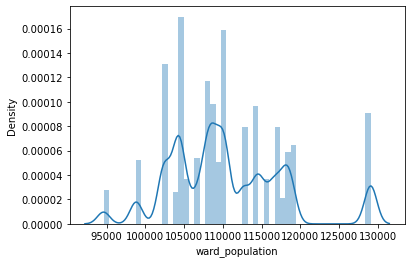

In [92]:
#the remaining values will be imputed based on their distribution
sns.distplot(df.ward_population)

In [94]:
#imputing ward population with mean
df['ward_population']=df['ward_population'].fillna(df['ward_population'].mean())

In [95]:
df.isnull().sum()

Date                     0
Time                     0
Day                      0
Incident                 0
Min Delay                0
Min Gap                  0
Fleet                    0
stop_name                0
Route                    0
ward_name                0
ward_population          0
ward_median_age       5561
ward_median_income    5561
dtype: int64

/Users/Amaikuru/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ward_median_age', ylabel='Density'>

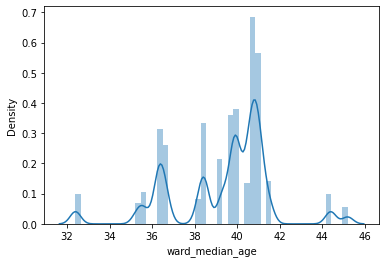

In [96]:
sns.distplot(df.ward_median_age)

In [97]:
#imputing ward_median_age with the median value
df['ward_median_age']=df['ward_median_age'].fillna(df['ward_median_age'].median())

/Users/Amaikuru/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ward_median_income', ylabel='Density'>

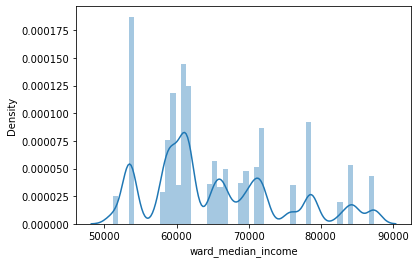

In [98]:
sns.distplot(df.ward_median_income)

In [99]:
#imputing ward_median_income with the median value
df['ward_median_income']=df['ward_median_income'].fillna(df['ward_median_income'].median())

In [100]:
df.isnull().sum()

Date                  0
Time                  0
Day                   0
Incident              0
Min Delay             0
Min Gap               0
Fleet                 0
stop_name             0
Route                 0
ward_name             0
ward_population       0
ward_median_age       0
ward_median_income    0
dtype: int64

### 07 Including number of stops,  stations( and distance to nearest), points of interest, schools and places of worship in every ward

In [161]:
poi=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'interest_dict.csv'))
schools=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'school_dict.csv'))
worship=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'worship_dict.csv'))
stations=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'stops_stations.csv'))
nstations=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'station_dict.csv'))
nstops=pd.read_csv(os.path.join(path, '02 Data','Prepared', 'stops_dict.csv'))

In [162]:
poi.columns

Index(['Unnamed: 0', 'Ward_name', 'n_poi'], dtype='object')

In [163]:
poi=poi[['Ward_name','n_poi']]

In [164]:
poi

Ward_name  n_poi
0          Beaches-East York      4
1                  Davenport      2
2            Don Valley East      2
3           Don Valley North      2
4            Don Valley West      2
5          Eglinton-Lawrence      1
6           Etobicoke Centre      4
7            Etobicoke North      6
8        Etobicoke-Lakeshore      5
9   Humber River-Black Creek      1
10        Parkdale-High Park      5
11        Scarborough Centre      1
12         Scarborough North      1
13     Scarborough Southwest      2
14     Scarborough-Guildwood      3
15    Scarborough-Rouge Park      4
16         Spadina-Fort York     54
17            Toronto Centre     36
18          Toronto-Danforth      6
19        Toronto-St. Paul's      5
20       University-Rosedale     23
21                Willowdale      3
22               York Centre      1

In [176]:
df['ward_name'].value_counts()

York Centre                 6068
Scarborough Southwest       5739
Humber River-Black Creek    5426
Eglinton-Lawrence           4471
Etobicoke-Lakeshore         4208
York South-Weston           3688
Scarborough Centre          3673
Toronto-St. Paul's          3455
Willowdale                  2981
Parkdale-High Park          2789
Etobicoke North             2751
Scarborough-Rouge Park      2590
Toronto-Danforth            2520
Scarborough North           2421
Beaches-East York           2339
outside_wards               2106
Don Valley West             2088
University-Rosedale         1804
Davenport                   1770
Spadina-Fort York           1720
Scarborough-Agincourt       1710
Don Valley North            1615
Scarborough-Guildwood       1406
Don Valley East             1307
Toronto Centre              1217
Etobicoke Centre             969
Name: ward_name, dtype: int64

In [166]:
#creating lists from columns
ward_names=list(poi['Ward_name'])
npoi=list(poi['n_poi'])


In [167]:
#creating dictionary
pois=dict(zip(ward_names,npoi))

In [168]:
df.columns

Index(['Date', 'Time', 'Day', 'Incident', 'Min Delay', 'Min Gap', 'Fleet',
       'stop_name', 'Route', 'ward_name', 'ward_population', 'ward_median_age',
       'ward_median_income', 'n_poi'],
      dtype='object')

In [172]:
#mapping to df
df['n_poi'] = df['ward_name'].map(pois)

In [173]:
df.isnull().sum()

Date                     0
Time                     0
Day                      0
Incident                 0
Min Delay                0
Min Gap                  0
Fleet                    0
stop_name                0
Route                    0
ward_name                0
ward_population          0
ward_median_age          0
ward_median_income       0
n_poi                 7504
dtype: int64

In [174]:
nulls=df.loc[df['n_poi'].isnull()==True]

In [175]:
nulls['ward_name'].value_counts()

York South-Weston        3688
outside_wards            2106
Scarborough-Agincourt    1710
Name: ward_name, dtype: int64

In [177]:
ward_names

['Beaches-East York',
 'Davenport',
 'Don Valley East',
 'Don Valley North',
 'Don Valley West',
 'Eglinton-Lawrence',
 'Etobicoke Centre',
 'Etobicoke North',
 'Etobicoke-Lakeshore',
 'Humber River-Black Creek',
 'Parkdale-High Park',
 'Scarborough Centre',
 'Scarborough North',
 'Scarborough Southwest',
 'Scarborough-Guildwood',
 'Scarborough-Rouge Park',
 'Spadina-Fort York',
 'Toronto Centre',
 'Toronto-Danforth',
 "Toronto-St. Paul's",
 'University-Rosedale',
 'Willowdale',
 'York Centre']

#### these wards have 0 points of interest 

In [180]:
#imputing null values with 0
df['n_poi']=df['n_poi'].fillna(0)

In [181]:
df.isnull().sum()

Date                  0
Time                  0
Day                   0
Incident              0
Min Delay             0
Min Gap               0
Fleet                 0
stop_name             0
Route                 0
ward_name             0
ward_population       0
ward_median_age       0
ward_median_income    0
n_poi                 0
dtype: int64

In [182]:
schools.columns

Index(['Unnamed: 0', 'Ward_name', 'n_schools'], dtype='object')

In [183]:
schools=schools[['Ward_name','n_schools']]

In [184]:
#making lists out of columns
wards=list(schools['Ward_name'])
nschools=list(schools['n_schools'])


In [185]:
#making dictionaries
school_dict=dict(zip(wards,nschools))


In [186]:
#mapping to df
df['n_schools'] = df['ward_name'].map(school_dict)

In [187]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  n_poi  n_schools  
0         118800.0             38.5             61189.0    3.0       64.0  
1         115510.0             32.4             75825.0   54.0       28.0  
2         104320.0             40.8             61725.0    1.0       45.0  
3         118800.0             38.5             61189.0    3.0       64.0  
4         108805.0             38.4             65546.0    5.0       42.0

In [188]:
df.isnull().sum()

Date                     0
Time                     0
Day                      0
Incident                 0
Min Delay                0
Min Gap                  0
Fleet                    0
stop_name                0
Route                    0
ward_name                0
ward_population          0
ward_median_age          0
ward_median_income       0
n_poi                    0
n_schools             2106
dtype: int64

In [190]:
#locating nulls
nulls=df.loc[df['n_schools'].isnull()==True]

In [192]:
nulls['ward_name'].value_counts()

outside_wards    2106
Name: ward_name, dtype: int64

In [193]:
#they are all outside wards, will be imputing with 0
df['n_schools']=df['n_schools'].fillna(0)

In [194]:
#filling number of places of worship
worship.columns

Index(['Unnamed: 0', 'Ward_name', 'n_worship'], dtype='object')

In [195]:
worship=worship[['Ward_name','n_worship']]

In [196]:
#making lists from columns
wards=list(worship['Ward_name'])
nworship=list(worship['n_worship'])

In [197]:
#making dictionaries
wor_dict=dict(zip(wards,nworship))

In [199]:
#mapping to df
df['n_worship'] = df['ward_name'].map(wor_dict)

In [200]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  n_poi  n_schools  \
0         118800.0             38.5             61189.0    3.0       64.0   
1         115510.0             32.4             75825.0   54.0       28.0   
2         104320.0             40.8             61725.0    1.0       45.0   
3         118800.0             38.5             61189.0    3.0       64.0   
4         108805.0             38.4             65546.0    5.0       42.0   

   n_worship  
0       41.0  
1       24.0  
2       73.0  
3       41.0  
4       73.0

In [201]:
df.isnull().sum()

Date                     0
Time                     0
Day                      0
Incident                 0
Min Delay                0
Min Gap                  0
Fleet                    0
stop_name                0
Route                    0
ward_name                0
ward_population          0
ward_median_age          0
ward_median_income       0
n_poi                    0
n_schools                0
n_worship             2106
dtype: int64

In [202]:
nulls=df.loc[df['n_worship'].isnull()==True]

In [203]:
nulls['ward_name'].value_counts()

outside_wards    2106
Name: ward_name, dtype: int64

In [204]:
#imputing with 0
df['n_worship']=df['n_worship'].fillna(0)

In [205]:
stations.columns

Index(['Unnamed: 0', 'stop_name', 'closest_station', 'dist'], dtype='object')

In [206]:
stations=stations[['stop_name','closest_station','dist']]

In [207]:
#making list of column entries
stops=list(stations['stop_name'])
station=list(stations['closest_station'])
dist=list(stations['dist'])

In [208]:
#making dictionary
stationn=dict(zip(stops,station))
distance=dict(zip(stops,dist))

In [209]:
#mapping to df
df['dist_to_nearest_station'] = df['stop_name'].map(distance)

In [210]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  n_poi  n_schools  \
0         118800.0             38.5             61189.0    3.0       64.0   
1         115510.0             32.4             75825.0   54.0       28.0   
2         104320.0             40.8             61725.0    1.0       45.0   
3         118800.0             38.5             61189.0    3.0       64.0   
4         108805.0             38.4             65546.0    5.0       42.0   

   n_worship  dist_to_nearest_station  
0       41.0                 0.015798  
1       24.0                 0.023542  
2       73.0                 0.023462  
3       41.0                 0.015798  
4       73.0                 0.000000

In [211]:
df.shape

(72831, 17)

In [212]:
df.isnull().sum()

Date                       0
Time                       0
Day                        0
Incident                   0
Min Delay                  0
Min Gap                    0
Fleet                      0
stop_name                  0
Route                      0
ward_name                  0
ward_population            0
ward_median_age            0
ward_median_income         0
n_poi                      0
n_schools                  0
n_worship                  0
dist_to_nearest_station    0
dtype: int64

In [213]:
#adding number of stations
nstations.columns

Index(['Unnamed: 0', 'Ward_name', 'n_stations'], dtype='object')

In [214]:
nstations=nstations[['Ward_name','n_stations']]

In [215]:
#making lists
wards=list(nstations['Ward_name'])
stationss=list(nstations['n_stations'])

In [216]:
#making dictionary
stat_dict=dict(zip(wards,stationss))

In [217]:
#mapping to df
df['n_stations'] = df['ward_name'].map(stat_dict)

In [218]:
df.isnull().sum()

Date                          0
Time                          0
Day                           0
Incident                      0
Min Delay                     0
Min Gap                       0
Fleet                         0
stop_name                     0
Route                         0
ward_name                     0
ward_population               0
ward_median_age               0
ward_median_income            0
n_poi                         0
n_schools                     0
n_worship                     0
dist_to_nearest_station       0
n_stations                 6803
dtype: int64

In [219]:
nulls=df.loc[df['n_stations'].isnull()==True]

In [220]:
nulls['ward_name'].value_counts()

Scarborough North    2421
outside_wards        2106
Don Valley East      1307
Etobicoke Centre      969
Name: ward_name, dtype: int64

In [221]:
wards

['Beaches-East York',
 'Davenport',
 'Don Valley North',
 'Don Valley West',
 'Eglinton-Lawrence',
 'Etobicoke North',
 'Etobicoke-Lakeshore',
 'Humber River-Black Creek',
 'Parkdale-High Park',
 'Scarborough Centre',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Guildwood',
 'Scarborough-Rouge Park',
 'Spadina-Fort York',
 'Toronto Centre',
 'Toronto-Danforth',
 "Toronto-St. Paul's",
 'University-Rosedale',
 'Willowdale',
 'York Centre',
 'York South-Weston']

In [222]:
#there are no stations in these wards, imputing with 0
df['n_stations']=df['n_stations'].fillna(0)

In [223]:
#including number of stops
nstops.columns

Index(['Unnamed: 0', 'Ward_name', 'n_stops'], dtype='object')

In [224]:
nstops=nstops[['Ward_name','n_stops']]

In [225]:
#creating dictionay
stopdict=dict(zip((list(nstops['Ward_name'])),(list(nstops['n_stops']))))

In [228]:
#mapping to df
df['n_stops'] = df['ward_name'].map(stopdict)

In [230]:
df.isnull().sum()

Date                       0
Time                       0
Day                        0
Incident                   0
Min Delay                  0
Min Gap                    0
Fleet                      0
stop_name                  0
Route                      0
ward_name                  0
ward_population            0
ward_median_age            0
ward_median_income         0
n_poi                      0
n_schools                  0
n_worship                  0
dist_to_nearest_station    0
n_stations                 0
n_stops                    0
dtype: int64

In [231]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  n_poi  n_schools  \
0         118800.0             38.5             61189.0    3.0       64.0   
1         115510.0             32.4             75825.0   54.0       28.0   
2         104320.0             40.8             61725.0    1.0       45.0   
3         118800.0             38.5             61189.0    3.0       64.0   
4         108805.0             38.4             65546.0    5.0       42.0   

   n_worship  dist_to_nearest_station  n_stations  n_stops  
0       41.0                 0.015798        33.0      291  
1       24.0                 0.023542        18.0      205  
2       73.0                 0.023462        38.0      453  
3       41.0                 0.015798        33.0      291  
4       73.0                 0.000000        25.0      306

In [239]:
#counting stops on each route
unique_stops.head()

stop_name route_short_name Count  \
0               FINCH WEST STATION               36  4001   
1            EGLINTON WEST STATION               32  3495   
2  KING ST WEST AT JOE SHUSTER WAY              504  3396   
3          KING ST WEST AT SHAW ST              504  3396   
4       KING ST WEST AT SUDBURY ST              504  3396   

                                Joined  
0                FINCH WEST STATION-36  
1             EGLINTON WEST STATION-32  
2  KING ST WEST AT JOE SHUSTER WAY-504  
3          KING ST WEST AT SHAW ST-504  
4       KING ST WEST AT SUDBURY ST-504

In [240]:
stops=unique_stops[['stop_name','route_short_name']]

In [242]:
route_count=stops.groupby(["route_short_name"], as_index=False)["stop_name"].count()

In [243]:
route_count

route_short_name  stop_name
0                  1         76
1                 10         25
2                100         73
3                101         11
4                102        133
5                104         46
6                105         23
7                106         36
8                107         87
9                108         69
10               109         53
11                11         88
12               110         72
13               111         49
14               112         95
15               113         45
16               115         39
17               116         89
18               118         65
19               119         49
20                12        125
21               120         62
22               121         29
23               122         61
24               123         74
25               124         21
26               125         24
27               126         21
28               127         36
29               129         77
30                13         46
31               130         50
32               131         67
33               132         61
34               133         63
35               134         83
36               135         35
37                14         43
38                15         54
39                16         65
40               160         77
41               161         58
42               162         64
43               165        102
44               167         66
45               168         29
46               169         95
47                17         97
48               171         19
49               172         24
50               174          6
51               175         23
52               189         34
53                19         44
54                 2         62
55                20         63
56                21         73
57                22         34
58                23         31
59                24        118
60                25         89
61                26         58
62                28         19
63                29         81
64                 3         12
65                30         16
66               300        182
67               301        113
68               302        110
69               304         80
70               306         73
71               307        124
72                31         27
73               310         30
74               312         66
75               315         66
76                32        106
77               320        133
78               322         75
79               324        105
80               325        114
81               329        103
82                33         23
83               332         99
84               334        137
85               335        101
86               336        107
87               337        110
88               339         85
89                34         92
90               341         95
91               343         73
92                35        113
93               352        117
94               353        159
95               354        139
96                36        127
97               363         54
98               365         21
99                37        113
100               38         58
101              384         67
102              385        117
103               39        110
104              395        107
105              396        114
106                4         10
107               40         60
108              400         67
109              402         39
110              403         46
111              404         62
112              405         54
113               41         97
114               42         93
115               43         89
116               44         27
117               45        100
118               46         86
119               47         90
120               48         53
121               49         28
122               50         35
123              501        119
124 

In [245]:
route_count.rename(columns={'route_short_name':'Route'},inplace=True)

In [246]:
#creating dict
route_dict=dict(zip((list(route_count['Route'])),(list(route_count['stop_name']))))

In [247]:
#creating column for number of stops on each route
df['n_stops_route'] = df['Route'].map(route_dict)

In [248]:
df.head()

Date   Time     Day            Incident  Min Delay  Min Gap Fleet  \
0  1/1/21  04:26  Friday  Emergency Services          0        0  1553   
1  1/1/21  05:04  Friday          Mechanical         10        0  8144   
2  1/1/21  05:34  Friday          Mechanical         24       48  8365   
3  1/1/21  05:44  Friday  Emergency Services         15       30  8181   
4  1/1/21  06:21  Friday              Vision         30       60  3186   

                                 stop_name Route           ward_name  \
0  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
1               STRACHAN AVE AT CANNIFF ST    63   Spadina-Fort York   
2                           949 WILSON AVE    96         York Centre   
3  YONGE ST AT STEELES AVE WEST SOUTH SIDE   320          Willowdale   
4                             JANE STATION    35  Parkdale-High Park   

   ward_population  ward_median_age  ward_median_income  n_poi  n_schools  \
0         118800.0             38.5             61189.0    3.0       64.0   
1         115510.0             32.4             75825.0   54.0       28.0   
2         104320.0             40.8             61725.0    1.0       45.0   
3         118800.0             38.5             61189.0    3.0       64.0   
4         108805.0             38.4             65546.0    5.0       42.0   

   n_worship  dist_to_nearest_station  n_stations  n_stops  n_stops_route  
0       41.0                 0.015798        33.0      291            133  
1       24.0                 0.023542        18.0      205             57  
2       73.0                 0.023462        38.0      453            163  
3       41.0                 0.015798        33.0      291            133  
4       73.0                 0.000000        25.0      306            113

In [249]:
df.isnull().sum()

Date                       0
Time                       0
Day                        0
Incident                   0
Min Delay                  0
Min Gap                    0
Fleet                      0
stop_name                  0
Route                      0
ward_name                  0
ward_population            0
ward_median_age            0
ward_median_income         0
n_poi                      0
n_schools                  0
n_worship                  0
dist_to_nearest_station    0
n_stations                 0
n_stops                    0
n_stops_route              0
dtype: int64

In [250]:
df.shape

(72831, 20)

## 3 Exporting df

In [251]:
#exporting wrangled dataset
df.to_pickle(os.path.join(path, '02 Data','Prepared', 'stops_wrangled.pkl'))